# Google Colab (GC) - Numba CPU

Este Notebook é um resumo dos originais disponíveis em:

https://github.com/efurlanm/tama21

## Hardware

* 1 cpu física + 1 cpu lógica *hyperthreading*
* 1 GPU Nvidia (geralmente Tesla K80)
* vetorização AVX2
* 12 GB RAM

## Fortran 90 sequencial (apenas para referência)

In [1]:
! gfortran -O3 -o heat_seq heat_seq.f90

In [2]:
! time ./heat_seq

Heat: 750.0000

real	0m3.105s
user	0m3.029s
sys	0m0.052s


>Comparando com o SD:
>
>        real	0m3.121s
>        user	0m2.965s
>        sys	 0m0.082s

# Python sequencial, sem Numba

In [3]:
def pyheat(n) :
    import numpy as np
    
    energy       = 1.0
    niters       = 250
    anew         = np.zeros((n + 2,  n + 2), np.float64)
    aold         = np.zeros((n + 2,  n + 2), np.float64)
    sources      = np.empty((3, 2), np.int16)
    sources[:,:] = [ [n//2, n//2], [n//3, n//3], [n*4//5, n*8//9] ]

    def kernel(anew, aold) :
        anew[1:-1,1:-1] = (aold[1:-1,1:-1]/2.0
                           +(aold[2:,1:-1]+aold[:-2,1:-1]
                           +aold[1:-1,2:]+aold[1:-1,:-2])/8.0)

    for _ in range(0, niters, 2):
        kernel(anew, aold)
        anew[sources[:, 0], sources[:, 1]] += energy
        kernel(aold, anew)
        aold[sources[:, 0], sources[:, 1]] += energy

    heat = np.sum(aold[1:-1, 1:-1])
    
    return heat, aold

Executa:

In [4]:
%%timeit -n1 -r1
heat, result = pyheat(2400)
print(f"Heat: {heat:.4f}")

Heat: 750.0000
1 loop, best of 1: 22 s per loop


## Mostra visualmente o resultado (exemplo)

In [6]:
import numpy as np
np.set_printoptions(precision=1, floatmode='fixed')
heat, result = pyheat(8)
result

array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
       [0.0, 0.8, 1.5, 1.3, 1.0, 0.8, 0.6, 0.4, 0.2, 0.0],
       [0.0, 1.5, 4.0, 2.6, 2.1, 1.6, 1.2, 0.8, 0.4, 0.0],
       [0.0, 1.3, 2.5, 2.8, 3.1, 2.4, 1.8, 1.2, 0.6, 0.0],
       [0.0, 1.0, 2.1, 3.1, 5.1, 3.1, 2.3, 1.7, 0.9, 0.0],
       [0.0, 0.8, 1.6, 2.3, 3.1, 2.7, 2.5, 2.4, 1.2, 0.0],
       [0.0, 0.6, 1.1, 1.6, 2.1, 2.2, 2.6, 4.1, 1.6, 0.0],
       [0.0, 0.4, 0.7, 1.0, 1.3, 1.5, 1.7, 1.9, 1.0, 0.0],
       [0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.8, 0.4, 0.0],
       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

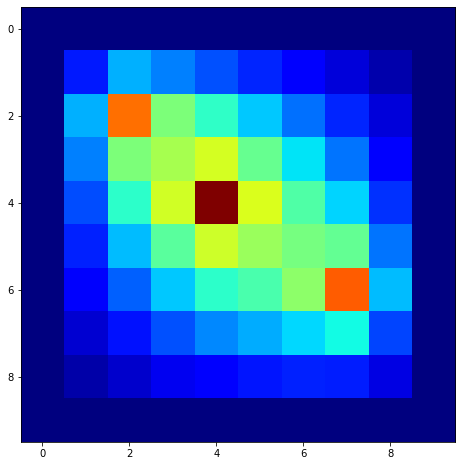

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.imshow(result, cmap='jet')

---

# Numba paralelo, usando *thread*

In [10]:
def nbheat(tr) :
    import numpy as np
    from numba import set_num_threads, get_num_threads, \
                      threading_layer, njit, config

    n            = 2400
    energy       = 1.0
    niters       = 250
    anew         = np.zeros((n + 2,  n + 2), np.float64)
    aold         = np.zeros((n + 2,  n + 2), np.float64)
    sources      = np.empty((3, 2), np.int16)
    sources[:,:] = [ [n//2, n//2], [n//3, n//3], [n*4//5, n*8//9] ]

# parte que é diferente
#----------------------------------------
    config.THREADING_LAYER = 'omp'    # OpenMP
    set_num_threads(tr)    # seta a qtde. de threads
    @njit('(float64[:,:],float64[:,:])', parallel=True, \
            fastmath=True, nogil=True)
#----------------------------------------
    def kernel(anew, aold) :
        anew[1:-1,1:-1] = (aold[1:-1,1:-1]/2.0
                           +(aold[2:,1:-1]+aold[:-2,1:-1]
                           +aold[1:-1,2:]+aold[1:-1,:-2])/8.0)

    for _ in range(0, niters, 2) :
        kernel(anew, aold)
        anew[sources[:, 0], sources[:, 1]] += energy
        kernel(aold, anew)
        aold[sources[:, 0], sources[:, 1]] += energy

    heat = np.sum(aold[1:-1, 1:-1])
    
    return heat, aold, threading_layer(), get_num_threads()

In [11]:
%%timeit -n1 -r1
heat, result, TL, NT = nbheat(1)
print(f"Heat: {heat:.4f}", end=" | ")
print(f"Threading layer: {TL}", end=" | ")
print(f"Thread count: {NT}")

Heat: 750.0000 | Threading layer: omp | Thread count: 1
1 loop, best of 1: 4.02 s per loop


In [12]:
%%timeit -n1 -r1
heat, result, TL, NT = nbheat(2)
print(f"Heat: {heat:.4f}", end=" | ")
print(f"Threading layer: {TL}", end=" | ")
print(f"Thread count: {NT}")

Heat: 750.0000 | Threading layer: omp | Thread count: 2
1 loop, best of 1: 3.69 s per loop


Usando apenas dois threads, pois no GC apenas um núcleo físico e um virtual estão disponíveis.